In [121]:
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pyodbc
import pymssql
import sqlalchemy
from shapely import wkt
import ogr
import json
from bokeh.io import show
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure
from bokeh.tile_providers import get_provider, Vendors
from bokeh.plotting import figure, output_file, show

In [3]:
#load the data
data_path = r'\\AWS-Model10\Model Data 2\INRIX\trip_paths_usa_wa_puget_sound_201905\date=2020-12-29\reportId=45749\v1\data\trips'
os.chdir(data_path)

In [4]:
trips_header = pd.read_csv(os.path.join(r'\\AWS-Model10\Model Data 2\INRIX\trip_paths_usa_wa_puget_sound_201905\date=2020-12-29\reportId=45749\v1', 'schema', 'TripBulkReportTripsHeaders.csv'))
trips_df = pd.read_csv(os.path.join(data_path, 'trips.csv.gz'), compression='gzip', names = trips_header.columns)

In [20]:
pd.set_option('display.max_columns', None)
trips_df.head()

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,EndLocLat,EndLocLon,GeospatialType,ProviderType,ProviderDrivingProfile,VehicleWeightClass,ProbeSourceType,OriginZoneName,DestinationZoneName,EndpointType,TripMeanSpeedKph,TripMaxSpeedKph,TripDistanceMeters,MovementType,OriginCbg,DestCbg,StartTimezone,EndTimezone,WaypointFreqSec,StartQk,EndQk
0,a58741e59c39b039c50101f68d292349,d422c29ef06ec8dc7a3ad73858c1c70e,f033ab37c30201f73f142449d037028d,1,2019-05-20T22:53:34.034Z,1,2019-05-20T23:02:03.003Z,1,48.0001,-122.1159,48.0004,-122.1272,II,2,3,2,1,SNOHOMISH,SNOHOMISH,2,26.555007,54.345351,3754.354248,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,46.269909,21230012232320301,21230012232231301
1,e574a35bb513e4981424188726e9662a,1992ccba0a2d60701d03880371fdde6c,f033ab37c30201f73f142449d037028d,1,2019-05-20T23:59:59.059Z,1,2019-05-21T00:05:29.029Z,1,48.0545,-122.1876,48.0767,-122.1878,II,2,3,2,1,SNOHOMISH,SNOHOMISH,3,38.949262,94.146654,3570.024483,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,12.691154,21230012221332003,21230012221310003
2,fc7f4fe52cb94479ae9f7e5f6702e4de,93f7fc1ffabe1538010794e907f1703f,54229abfcfa5649e7003b83dd4755294,1,2019-05-21T15:22:48.048Z,2,2019-05-21T15:24:27.027Z,2,47.2385,-122.3682,47.2345,-122.3645,II,2,3,2,1,PIERCE,PIERCE,2,19.756351,21.541364,543.184395,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,24.744750,21230023311303132,21230023311312222
3,88ed8f34f208ec74ff05272fd57ebe12,fcc676d1dc8eeececfc8251a08a47913,54229abfcfa5649e7003b83dd4755294,1,2019-05-21T19:36:31.031Z,2,2019-05-21T20:06:33.033Z,2,47.4535,-122.2233,47.2098,-122.3003,II,2,3,2,1,KING,PIERCE,3,66.460610,95.820417,33267.264305,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,78.347913,21230032003010311,21230032202013131
4,1e9e9c070524cb976e5be7a0009197bb,fba11305da03375db0e7d26e2d69dcf5,f033ab37c30201f73f142449d037028d,1,2019-05-21T22:12:30.030Z,2,2019-05-21T22:22:29.029Z,2,47.9183,-122.1091,47.9359,-122.0796,II,2,3,2,1,SNOHOMISH,SNOHOMISH,3,28.006599,84.247798,4659.979105,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,59.899900,21230030012103212,21230030011222020


In [5]:
#number of trips recroded
len(pd.unique(trips_df['TripId'])) 

1242924

Vehicle types in the dataset
VehicleWeightClass - Lists one of three weight classes provider
    1 = Light Duty Truck/Passenger Vehicle: Ranges from 0 to 14,000 lb.
    2 = Medium Duty Trucks / Vans: ranges from 14001–26000 lb.
    3 = Heavy Duty Trucks: > 26000 lb.

In [10]:
trips_df.groupby('VehicleWeightClass').size()

VehicleWeightClass
2    1013601
3     229334
dtype: int64

Provider types and Provider driver profile
ProviderType - Describes the provider type
    1 = Consumer
    2 = Fleet
ProviderDrivingProfile -  Driving class, additional detail about type of provider
    1 = Consumer Vehicles
    2 = Taxi/shuttle/town car services
    3 = Field Service/Local Delivery Fleets
    4 = For hire/private trucking fleets

In [11]:
trips_df.groupby('ProviderType').size()
trips_df.groupby('ProviderDrivingProfile').size()

ProviderDrivingProfile
3    1013601
4     229334
dtype: int64

Data covers the following dates in 2019:
May 1st - 31st 2019
Number of trips during an average weekday ~47-55k
Number of trips during an average weekend ~9-18k

In [30]:
trips_df.dtypes

TripId                                 object
DeviceId                               object
ProviderId                             object
Mode                                    int64
StartDate                              object
StartWDay                               int64
EndDate                                object
EndWDay                                 int64
StartLocLat                           float64
StartLocLon                           float64
EndLocLat                             float64
EndLocLon                             float64
GeospatialType                         object
ProviderType                            int64
ProviderDrivingProfile                  int64
VehicleWeightClass                      int64
ProbeSourceType                         int64
OriginZoneName                         object
DestinationZoneName                    object
EndpointType                            int64
TripMeanSpeedKph                      float64
TripMaxSpeedKph                   

In [43]:
trips_df['StartDate_upd'] = pd.to_datetime(trips_df["StartDate"])
trips_df["StartDate_dmy"] = trips_df["StartDate_upd"].apply(lambda x: x.strftime('%d%m%Y'))

In [44]:
trips_df["StartDOW"] = trips_df["StartDate_upd"].apply(lambda x: x.strftime('%A'))

In [50]:
df_test = trips_df.groupby(["StartDate_dmy","StartDOW"]).size()

In [53]:
df_test = pd.DataFrame(df_test)

In [97]:
df_test.dtypes

,,0
StartDate_dmy,StartDOW,
01052019,Wednesday,51825
02052019,Thursday,51361
03052019,Friday,49319
04052019,Saturday,17639
05052019,Sunday,10125
06052019,Monday,47064
07052019,Tuesday,51382
08052019,Wednesday,52326
09052019,Thursday,52121


In [8]:
def read_from_sde(connection_string, feature_class_name,
                  crs={'init': 'epsg:2285'}):
    """
    Returns the specified feature class as a geodataframe from ElmerGeo.
    
    Parameters
    ----------
    connection_string : SQL connection string that is read by geopandas 
                        read_sql function
    
    feature_class_name: the name of the featureclass in PSRC's ElmerGeo 
                        Geodatabase
    
    cs: cordinate system
    """

    engine = sqlalchemy.create_engine(connection_string)
    con=engine.raw_connection()
    feature_class_name = feature_class_name + '_evw'
    df=pd.read_sql('select *, Shape.STAsText() as geometry from %s' % 
                   (feature_class_name), con=con)
    con.close()
    df['geometry'] = df['geometry'].apply(wkt.loads)
    gdf=gpd.GeoDataFrame(df, geometry='geometry')
    gdf.crs = crs
    cols = [col for col in gdf.columns if col not in 
            ['Shape', 'GDB_GEOMATTR_DATA', 'SDE_STATE_ID']]
    
    return gdf[cols]

In [9]:
gdb_connection_string = 'mssql+pyodbc://AWS-PROD-SQL\Sockeye/OSMTest?driver=SQL Server?Trusted_Connection=yes'
name = 'ElmerGeo.DBO.tract2010'
tracts = read_from_sde(gdb_connection_string,name )

C:\Users\pbutrina\AppData\Local\Continuum\anaconda3\envs\myenv\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [12]:
trips_d = gpd.GeoDataFrame(
    trips_df, geometry=gpd.points_from_xy(trips_df.EndLocLon, trips_df.EndLocLat))
trips_d.crs = "EPSG:4326"

In [13]:
trips_o = gpd.GeoDataFrame(
    trips_df, geometry=gpd.points_from_xy(trips_df.StartLocLon, trips_df.StartLocLat))
trips_o.crs = "EPSG:4326"

In [14]:
tracts = tracts.to_crs(epsg=4326)

In [66]:
tract_trips_o = gpd.sjoin(tracts, trips_o, how='inner', op='intersects')
tract_trips_d = gpd.sjoin(tracts, trips_d, how='inner', op='intersects')


In [143]:
tract_trips_o=tract_trips_o.groupby('namelsad10')['namelsad10'].count().reset_index(name='count').sort_values(by=['count'])

In [144]:
tract_trips_o

,namelsad10,count
770,Census Tract 9900.02,93
681,Census Tract 8,100
201,Census Tract 294.08,100
707,Census Tract 9,101
684,Census Tract 801.01,108
...,...,...
148,Census Tract 262,25675
749,Census Tract 93,28444
499,Census Tract 602,30550
666,Census Tract 733.01,40305


In [67]:
tract_trips_o.groupby('namelsad10')['namelsad10'].count().reset_index(name='count').sort_values(by=['count'])

,namelsad10,count
770,Census Tract 9900.02,93
681,Census Tract 8,100
201,Census Tract 294.08,100
707,Census Tract 9,101
684,Census Tract 801.01,108
...,...,...
148,Census Tract 262,25675
749,Census Tract 93,28444
499,Census Tract 602,30550
666,Census Tract 733.01,40305


In [147]:
tract_trips_o.describe()

,count
count,772.000000
mean,1499.152850
std,3381.411163
min,93.000000
25%,494.500000
50%,783.500000
75%,1377.500000
max,52796.000000


In [58]:
tract_trips_d=tract_trips_d.groupby('namelsad10')['namelsad10'].count().reset_index(name='count').sort_values(by=['count'])

In [65]:
tract_trips_d.groupby('namelsad10')['namelsad10'].count().reset_index(name='count').sort_values(by=['count'])

,namelsad10,count
0,Census Tract 1,1
509,Census Tract 609.06,1
510,Census Tract 61,1
511,Census Tract 610.01,1
512,Census Tract 610.02,1
...,...,...
260,Census Tract 317.04,1
261,Census Tract 317.05,1
262,Census Tract 317.06,1
288,Census Tract 322.13,1


In [59]:
d_by_tract_count = pd.merge(tract_trips_d, tracts,on=["namelsad10"])

In [60]:
o_by_tract_count = pd.merge(tract_trips_o, tracts,on=["namelsad10"])

In [61]:
d_by_tract_count.head(20)

,namelsad10,count,OBJECTID,statefp10,countyfp10,tractce10,geoid10,name10,mtfcc10,funcstat10,aland10,awater10,intptlat10,intptlon10,name_val,geometry
0,Census Tract 9900.02,51,654,53,061,990002,53061990002,9900.02,G5020,S,0.0,176297876.0,+48.0002690,-122.3350510,9900.0,"POLYGON ((-122.23004 48.02477, -122.23143 48.0..."
1,Census Tract 294.08,88,278,53,033,029408,53033029408,294.08,G5020,S,1238188.0,0.0,+47.3946962,-122.1916681,294.0,"POLYGON ((-122.19267 47.38695, -122.19195 47.3..."
2,Census Tract 8,99,21,53,033,000800,53033000800,8,G5020,S,1141587.0,0.0,+47.7112492,-122.2860821,8.0,"POLYGON ((-122.29136 47.71732, -122.29150 47.7..."
3,Census Tract 9,101,394,53,033,000900,53033000900,9,G5020,S,996458.0,2531309.0,+47.7063747,-122.2749586,9.0,"POLYGON ((-122.28322 47.71919, -122.28326 47.7..."
4,Census Tract 801.01,108,403,53,035,080101,53035080101,801.01,G5020,S,2222361.0,313851.0,+47.5971070,-122.6486496,801.0,"POLYGON ((-122.63998 47.59740, -122.63995 47.5..."
5,Census Tract 808,132,443,53,035,080800,53035080800,808,G5020,S,1095272.0,596310.0,+47.5877911,-122.6911832,808.0,"POLYGON ((-122.68261 47.58178, -122.68259 47.5..."
6,Census Tract 10,145,393,53,033,001000,53033001000,10,G5020,S,954457.0,0.0,+47.7064067,-122.2960648,10.0,"POLYGON ((-122.30162 47.70475, -122.30162 47.7..."
7,Census Tract 9400.06,148,458,53,053,940006,53053940006,9400.06,G5020,S,1825313.0,0.0,+47.2153941,-122.4012241,9400.0,"POLYGON ((-122.40768 47.21919, -122.40766 47.2..."
8,Census Tract 15,158,388,53,033,001500,53033001500,15,G5020,S,1170487.0,398486.0,+47.6945678,-122.3949423,15.0,"POLYGON ((-122.40187 47.69431, -122.40102 47.6..."
9,Census Tract 45,161,324,53,033,004500,53033004500,45,G5020,S,671000.0,0.0,+47.6685824,-122.3229111,45.0,"POLYGON ((-122.32522 47.67226, -122.32549 47.6..."


In [63]:
d_by_tract_count = gpd.GeoDataFrame(d_by_tract_count, crs="EPSG:4326", geometry='geometry')
o_by_tract_count = gpd.GeoDataFrame(o_by_tract_count, crs="EPSG:4326", geometry='geometry')

(47.0, 48.0)

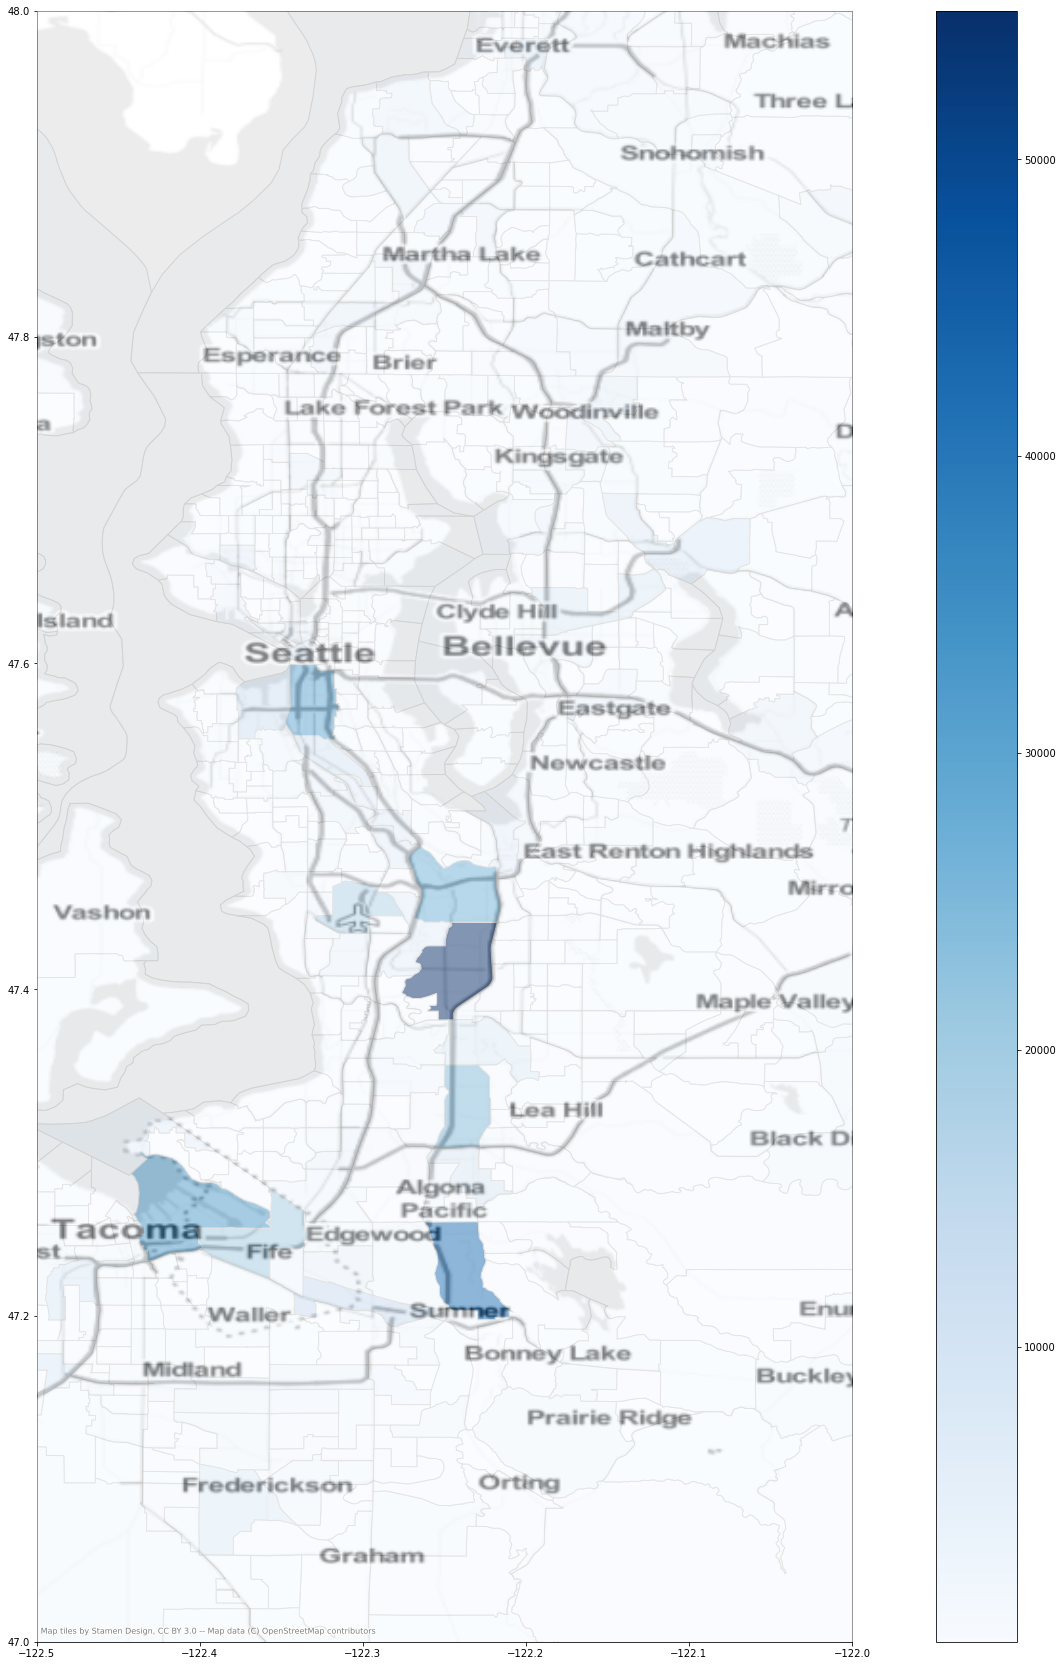

In [135]:
variable = 'count'
# set the range for the choropleth
vmin, vmax = 50, 55000
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 30))
# create map
d_by_tract_count.plot(column='count', cmap='Blues', ax=ax,  edgecolor='0.8')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=10, alpha=0.5, zorder=8 , crs='EPSG:4326' )


In [133]:
dir(ax)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_box_aspect',
 '_clipon',
 '_clippath',
 '_contains',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_axis_map',
 '_get_clipping_extent_bbox',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_in_layout',

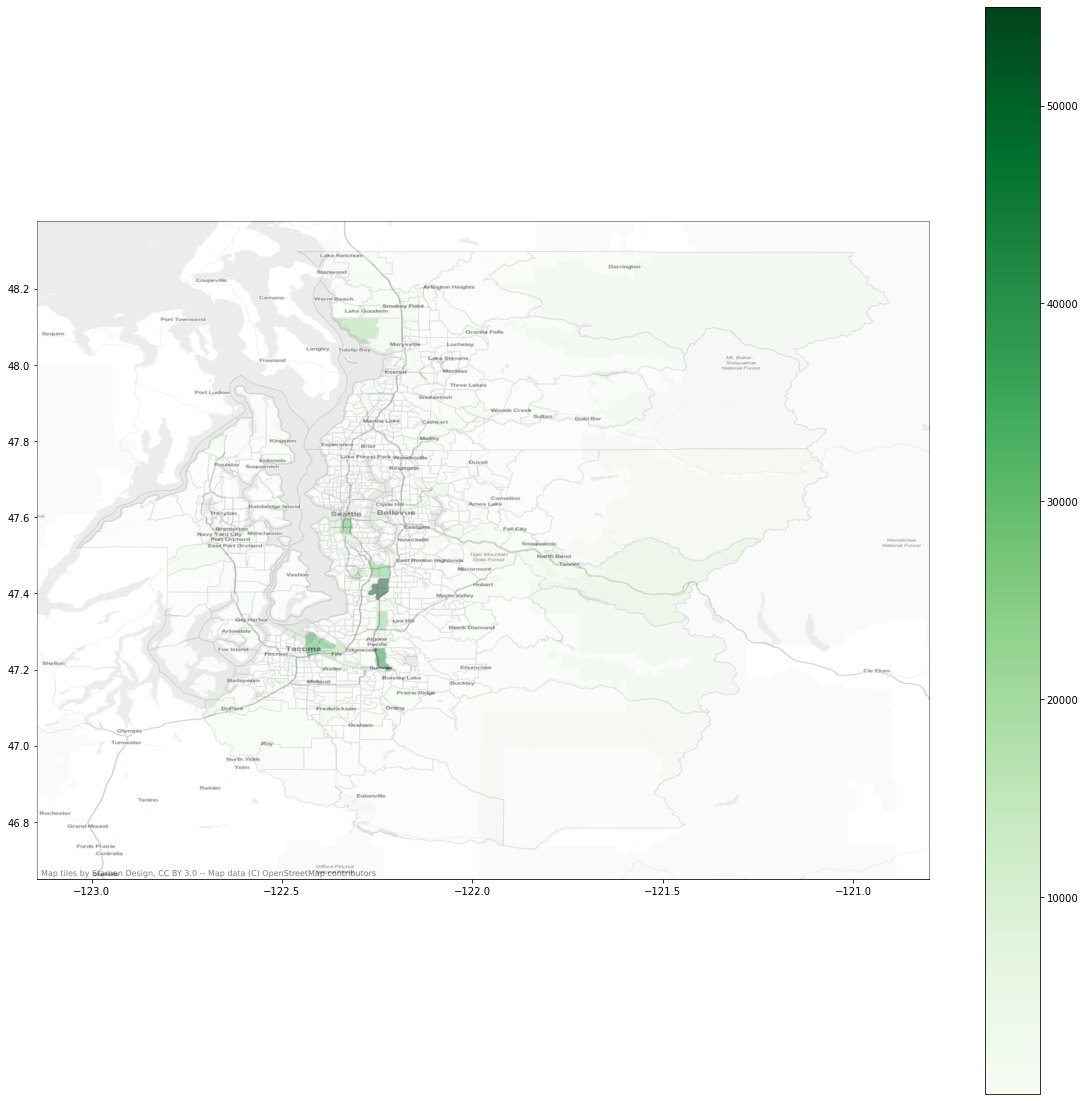

In [119]:
variable = 'count'
# set the range for the choropleth
vmin, vmax = 50, 55000
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 20))
# create map
o_by_tract_count.plot(column='count', cmap='Greens', ax=ax,  edgecolor='0.8')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=10, alpha=0.5, zorder=8 , crs='EPSG:4326' )

In [159]:
geosource = GeoJSONDataSource(geojson = o_by_tract_count.to_crs(3857).to_json())
output_file("C:/Users/pbutrina/Documents/o_by_tract_may2019.html")
# Define color palettes
#tile_provider = get_provider(Vendors.STAMEN_TONER)
tile_provider = get_provider(Vendors.OSM)
palette = brewer['BuGn'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors
# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 50000)
# Define custom tick labels for color bar.
tick_labels = {'0': '0', '500': '500',
 '1000':'1,000', '5000':'5,000',
 '10000':'10,000', '20000':'20,000',
 '30000':'30,000', '50000':'30,000+'}
# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)
# Create figure object.
p = figure(title = 'Truck Origins Grouped by Census Tract, May 2019', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = 'pan, wheel_zoom, box_zoom, reset')
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.
states = p.patches('xs','ys', source = geosource,fill_alpha=0.6,
                   fill_color = {'field':'count',
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25)
# Create hover tool
p.add_tools(HoverTool(renderers = [states],
                     tooltips = [('Tract','@tractce10'),
                               ('count', '@count')]))
# Specify layout
p.add_layout(color_bar, 'below')
p.add_tile(tile_provider)
show(p)

In [158]:
geosource = GeoJSONDataSource(geojson = d_by_tract_count.to_crs(3857).to_json())
output_file("C:/Users/pbutrina/Documents/d_by_tract_may2019.html")
# Define color palettes
#tile_provider = get_provider(Vendors.STAMEN_TONER)
tile_provider = get_provider(Vendors.OSM)
palette = brewer['OrRd'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors
# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 50000)
# Define custom tick labels for color bar.
tick_labels = {'0': '0', '500': '500',
 '1000':'1,000', '5000':'5,000',
 '10000':'10,000', '20000':'20,000',
 '30000':'30,000', '50000':'30,000+'}
# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)
# Create figure object.
p = figure(title = 'Truck Destinations Grouped by Census Tract, May 2019', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = 'pan, wheel_zoom, box_zoom, reset')
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.
states = p.patches('xs','ys', source = geosource,fill_alpha=0.6,
                   fill_color = {'field':'count',
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25)
# Create hover tool
p.add_tools(HoverTool(renderers = [states],
                     tooltips = [('Tract','@tractce10'),
                               ('count', '@count')]))
# Specify layout
p.add_layout(color_bar, 'below')
p.add_tile(tile_provider)
show(p)